The goal here is to modify the notebook that calculates and the cluster pdfs from multiple outputs.<br>
Ensure that all the out files are already present. <br>
Like in `Main_cluster_analysis.ipynb`, this notebook will separate the plotting feature into a function which takes bunch of user defined parameters

Import modules


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import matplotlib
from matplotlib.ticker import MaxNLocator,FormatStrFormatter
import pickle
from glob import glob
import sys  
import matplotlib.gridspec as gridspec
from scipy.stats import linregress
from dateutil.relativedelta import relativedelta
import itertools
import pickle
from cartopy.util import add_cyclic_point


from scipy.ndimage import label,find_objects
import scipy.ndimage as ndimage
from matplotlib.colors import LinearSegmentedColormap

import datetime as dt
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr
from scipy.stats import norm


%matplotlib inline

### Read inputs ###

In [2]:
! ls -altr /home/fiaz/cluster_analysis/*.out

-rw-r--r--. 1 fiaz fiaz  178426313 Jun 26 09:50 /home/fiaz/cluster_analysis/clusters_output_200801_200905.out
-rw-r--r--. 1 fiaz fiaz 1628735785 Jul  1 21:34 /home/fiaz/cluster_analysis/clusters_output_TRMM3B42_200201_201501.out
-rw-r--r--. 1 fiaz fiaz   30673433 Jul  8 16:48 /home/fiaz/cluster_analysis/clusters_output_SNU.SAM0-UNICON.out
-rw-r--r--. 1 fiaz fiaz  167709433 Jul  9 10:42 /home/fiaz/cluster_analysis/clusters_output_CESM.out
-rw-r--r--. 1 fiaz fiaz   46067257 Jul  9 10:44 /home/fiaz/cluster_analysis/clusters_output_NASA-GISS.out
-rw-rw-r--. 1 fiaz fiaz   73646137 Aug  9 16:17 /home/fiaz/cluster_analysis/clusters_output_CNRM-CM6-1.out
-rw-rw-r--. 1 fiaz fiaz   73646137 Aug  9 16:17 /home/fiaz/cluster_analysis/clusters_output_SSP585_CNRM-CM6-1.out
-rw-rw-r--. 1 fiaz fiaz   73646137 Aug 14 11:33 /home/fiaz/cluster_analysis/clusters_output_SSP585_CNRM-CM6-1_209801_210012.out
-rw-r--r--. 1 fiaz fiaz  178426313 Aug 18 09:21 /home/fiaz/cluster_analysis/clusters_output_TRMM3B42_20

### Get names of all models you want to plot ###
Creating three separate lists for observations (TRMM), historical and SSP runs.<br>
Note that the names here also contain the date extensions, so if the same model has different date ranges, you can pick one.<br>Or else you can also specify the two time periods as different model names.

In [3]:
obs_name=['TRMM3B42_201001_201212']
model_names_HIST=['BCC_3hr_201301_201412',
                  'CNRM-CM6-1-HR_201301_201412',
                 'CNRM-CM6-1_200501_201412']

model_names_SSP=['@BCC-CSM2-MR_209801_210012',
                 'CNRM-CM6-1-HR_209801_210012',
                'CNRM-CM6-1_209101_210012']
model_names_SSP=['SSP585_'+i for i in model_names_SSP] ## adding the SSP585 prefix to all models 

#### Get the file paths for all the models 

In [4]:
def read_files (dirc,namelist,cluster_dict):
    for i in namelist:
        file_path=dirc+'clusters_output_'+i+'.out'
        print('Reading '+file_path)
        file_name=glob(file_path)[0]
        with open(file_name, 'rb') as handle:
            cluster_dict[i] = pickle.load(handle)
    

In [5]:
### set the directory names for obs, hist and ssp; same in this case ###
dirc_obs="/home/fiaz/cluster_analysis/"
dirc_hist="/home/fiaz/cluster_analysis/"
dirc_ssp="/home/fiaz/cluster_analysis/"


In [6]:
### read all the info into the cluster_dict ###
cluster_dict={}
read_files(dirc_obs,obs_name,cluster_dict)
read_files(dirc_hist,model_names_HIST,cluster_dict)
read_files(dirc_ssp,model_names_SSP,cluster_dict)

Reading /home/fiaz/cluster_analysis/clusters_output_TRMM3B42_201001_201212.out
Reading /home/fiaz/cluster_analysis/clusters_output_BCC_3hr_201301_201412.out
Reading /home/fiaz/cluster_analysis/clusters_output_CNRM-CM6-1-HR_201301_201412.out
Reading /home/fiaz/cluster_analysis/clusters_output_CNRM-CM6-1_200501_201412.out
Reading /home/fiaz/cluster_analysis/clusters_output_SSP585_@BCC-CSM2-MR_209801_210012.out
Reading /home/fiaz/cluster_analysis/clusters_output_SSP585_CNRM-CM6-1-HR_209801_210012.out
Reading /home/fiaz/cluster_analysis/clusters_output_SSP585_CNRM-CM6-1_209101_210012.out


### Specify files to compare ###
As an example, we will just compare the historical model outputs to the TRMM3B42 <br>

In [7]:
data_keys=obs_name+model_names_HIST
### to compare only the SSP models, uncomment the following line
# data_keys=model_name_SSP

### Set thresholds to compare ###
#### default is set to 1 mm/hr; change to other thresholds to play around

In [8]:
### get list of precip. thresholds ###
pthresh_list_full=list(cluster_dict[obs_name[0]]['hist_pcp_sizes'].keys())
pthresh_ix=pthresh_list_full.index(1.0)  ### change to 1.0, 0.75, 0.50, 0.25
pthresh_list=pthresh_list_full[pthresh_ix:pthresh_ix+1]
pthresh_list

[1.0]

In [9]:
### Define function to extract and plot cluster information ###

nthresh=25

def extract_grid_info(dict_input):
    
    sizes=dict_input['sizes']
    sz=(sizes[:-1]+sizes[1:])*0.5
    sz_diff=np.diff(sizes)   
    
    precip_cluster_power_scale=dict_input['precip_cluster_power_scale']
    pcp_clus_pow_bins=sizes*precip_cluster_power_scale*0.5
    pcp_clust_sz=(pcp_clus_pow_bins[:-1]+pcp_clus_pow_bins[1:])*0.5
    
    pcp_clust_sz_diff=np.diff(pcp_clus_pow_bins)

    power_scale=dict_input['precip_cluster_power_scale']
    pixels_to_area=dict_input['pixels_to_area']

    return sz,pcp_clust_sz,sz_diff,pcp_clust_sz_diff,power_scale,pixels_to_area


def compute_pdfs(cluster_dict,pthresh):
    
    hist_pcp_sizes={}
    hist_pcp_clust_pow={}
    
    hist_pcp_clust_size_pdf={}
    hist_pcp_clust_pow_pdf={}
    
    pcp_sizes={}
    pcp_power={}
    
    sz={}
    pcp_clust_sz={}
    sz_diff={}
    pcp_clust_sz_diff={}
    power_scale={}
    pixels_to_area={}
    am={}
    cm={}
    
    ### Read power and size
    
    hist_pcp_sizes=cluster_dict['hist_pcp_sizes'][pthresh]
    hist_pcp_clust_pow=cluster_dict['hist_pcp_clust_pow'][pthresh]
    
    pcp_sizes=cluster_dict['pcp_sizes'][pthresh]
    pcp_power=cluster_dict['pcp_power'][pthresh]

    ### Get grid information
        
    sz,pcp_clust_sz,sz_diff,pcp_clust_sz_diff,power_scale, pixels_to_area=extract_grid_info(cluster_dict)
        
    hist_pcp_clust_size_pdf=hist_pcp_sizes/(sz_diff*pixels_to_area*hist_pcp_sizes.sum())
    hist_pcp_clust_size_pdf[hist_pcp_sizes<nthresh]=np.nan

    hist_pcp_clust_pow_pdf=hist_pcp_clust_pow/(pcp_clust_sz_diff*hist_pcp_clust_pow.sum())
    hist_pcp_clust_pow_pdf[hist_pcp_clust_pow==0]=np.nan

    am=np.mean(pcp_sizes**2)*pixels_to_area/np.mean(pcp_sizes)
    cm=np.mean(pcp_power**2)/np.mean(pcp_power)
    sz_scaled=sz*pixels_to_area
        
    return hist_pcp_clust_size_pdf, hist_pcp_clust_pow_pdf, am, cm, sz_scaled, pcp_clust_sz, sz_diff*pixels_to_area, pcp_clust_sz_diff


def shift_pdf(pdf, ref_pdf, xval, ref_xval, offsets, second_shift ):
    ind_max=np.nanargmax(pdf)
    xmax=xval[ind_max]
    ind_ref_max=np.argmin(abs(ref_xval-xmax))
    first_shift=ref_pdf[ind_ref_max]/pdf[ind_max]    
    shifted_pdf=pdf*first_shift*second_shift
    offsets=offsets*first_shift*second_shift
    return shifted_pdf,offsets
    

def wilson_score(ns,n,alpha):
    
        '''
        Here ns is the number of sucesses in a Bernoulli Trial, i.e., the number of samples in a given bin
        n is the number of Bernoulli trials, i.e., the number of samples overall
        alpha is the percent of confidence interval (e.g. 5%)
        '''        
        z=norm.ppf(alpha/2) ## get the probit of the confidence interval
#         err_upper=(ns/n)+z*np.sqrt(ns*(n-ns))/(n*np.sqrt(n))
#         err_lower=(ns/n-z)*np.sqrt(ns*(n-ns))/(n*np.sqrt(n))
    
        err_upper=(ns+0.5*z**2)/(n+z**2)+z/(n+z**2)*np.sqrt(ns*(n-ns)/n+z**2/4)
        err_lower=(ns+0.5*z**2)/(n+z**2)-z/(n+z**2)*np.sqrt(ns*(n-ns)/n+z**2/4)

        return err_lower, err_upper

def get_errors(hist, pdf, diff, alpha):

    error_lower,error_upper=wilson_score(hist,hist.sum(),alpha)
    error=np.array((error_lower/diff,error_upper/diff))
    offsets=abs(pdf-error)## create error bars
    
    return offsets

### Plot PDFs ##

In [10]:
### Some user defined parameters ###
nthresh=10 #Discard bins with fewer than nthresh samples
istrt_sz,iend_sz=2.0,5.0 ## the power law range for size (10^3 to 10^5)
istrt_pow,iend_pow=3.0,5.0 ### set a ballpark range for the power law, so the straight line fit is over that range

title_fontsize=15
xlabel_fontsize=16.5
ylabel_fontsize=16.5

## x and yaxis limits for cluster size
xlim_sz=[1e2,1e7] 
ylim_sz=[1e-23,1e0] ##

## x and yaxis limits for cluster power
xlim_pow=[5e2,1.0e8] ##
ylim_pow=[1e-22,1e-1] ##

## threshold legend font size
leg_fontsize=12.5

## moment ratio * power law slope font size
leg1_fontsize=13.5

## ticklabel font size
ticks_fontsize=14

### legend location ###
leg_loc=(.5, .65)

### errorbar options ###
errorbar=True
alpha=0.05


### set colors (same size as data keys)



In [1]:
colors=['black','red','green','orange']

#### We will artificially shift the each pdf by a factor  of (default=$10^{-2}$) for visual clarity

In [12]:
shift_factor=-3 ### shift is 1e-2
shifts={}
color_dicts={}
for i,j in enumerate(data_keys):
    color_dicts[j]=colors[i]
    shifts[j]=10**(shift_factor*i)

In [13]:
ref_pdf=compute_pdfs(cluster_dict[obs_name[0]],pthresh_list[0])    
ref_size_pdf,ref_power_pdf,ref_sz_scaled,ref_pow_scaled=ref_pdf[0],ref_pdf[1],ref_pdf[4],ref_pdf[5]
ref_am, ref_cm=ref_pdf[2],ref_pdf[3]

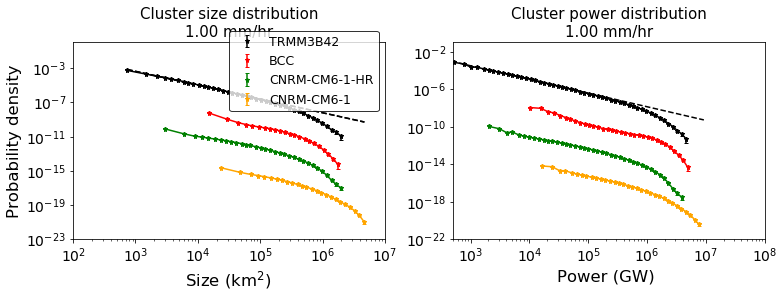

In [14]:
### set the plot specs:
### size
fig=plt.figure(figsize=(11,4.))
## grid: 1 row , 2 colum plot
gs = gridspec.GridSpec(1, 2)
## assign separate name for each axis
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])


### create empty dictionaries to hold the legends 
ln1={}
ln2={}

### positions for some of the text on the plot
posy=[ 0.85, 0.9, 0.95, 0.725, .8, .875 ]
posx=[.65, 0.65, 0.65, .4, .4 ]
pos_slope=[0.65, 0.9]

for j,key in enumerate(data_keys):

    istrt,iend=istrt_sz,iend_sz
    
    size_pdf, power_pdf, am, cm, sz_scaled, pcp_clust_sz,sz_diff, pcp_clust_sz_diff=compute_pdfs(cluster_dict[key],pthresh_list[0])
    
    hist=cluster_dict[key]['hist_pcp_sizes'][pthresh_list[0]]
    offsets=get_errors(hist, size_pdf, sz_diff, alpha)
    size_pdf,offsets=shift_pdf(size_pdf, ref_size_pdf, sz_scaled, ref_sz_scaled, offsets,shifts[key])

    size_pdf[hist<nthresh]=np.nan

    ### there are the start and end of the power law range: adjust according to eye ###
    ax1.loglog(sz_scaled,size_pdf,marker='*',
                        c=color_dicts[key],markersize=5)
    ln1[j]=ax1.errorbar(sz_scaled, size_pdf, yerr=offsets,fmt='*',
                        c=color_dicts[key],markersize=5,capsize=2.25)


    ### The straight line fit to the power law range ###
    ### select portions of the curve bounded by the power law range ###
    arrx,arry=np.log10(sz_scaled),np.log10(size_pdf)
    arrx_fin,arry_fin=arrx[np.logical_and(arrx>istrt,arrx<iend)],arry[np.logical_and(arrx>istrt,arrx<iend)]

    ### perform a linear regression over this selected portion ###
    try:
        ret=linregress(arrx_fin[np.isfinite(arry_fin)],arry_fin[np.isfinite(arry_fin)])
        ### Use the slope and intercept from the linear regression to create the straight line ###
        pdf_pcp_sizes=((sz_scaled)**(ret[0]))*(10**(ret[1]))
        ## Remove portions of the straight line that extend too far beyond the cutoff
        pdf_pcp_sizes[sz_scaled>5e6]=np.nan 

    except:
        pass

    
#     ### Now compute the moment ratio and print it in on plot ##
    if (j == 0):
        ax1.loglog(sz_scaled,pdf_pcp_sizes*1e0,linestyle='--',c=color_dicts[key])

        ### Set plot title and axis labels
        ax1.set_title("Cluster size distribution\n%.2f mm/hr"%(pthresh_list[0]),fontsize=title_fontsize)
        ax1.set_xlabel("Size ($\mathrm{km^2}$) ",fontsize=xlabel_fontsize)
        ax1.set_ylabel("Probability density",fontsize=ylabel_fontsize)
        ax1.set_xlim(xlim_sz)
        ax1.set_ylim(ylim_sz)
        ax1.yaxis.set_major_locator(plt.FixedLocator([1e0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10]))
        ax1.tick_params(which='both', labelsize=ticks_fontsize)
#         ax1.text(pos_slope[0], pos_slope[1],'$\\tau$=%.1f'%(-ret[0]),transform=ax1.transAxes,
#                 fontsize=leg1_fontsize,color='black')
        ax1.loglog(sz_scaled,pdf_pcp_sizes*1e0,linestyle='--',c='black')
    if j==len(data_keys)-1:
        leg_lines=[ln1[n] for n in ln1.keys()]
        leg_labels=["%s"%(n.split('_')[0]) for n in data_keys]

        leg=ax1.legend((leg_lines),(leg_labels),fontsize=leg_fontsize, loc=leg_loc,ncol=1 )
#         ## make legend box color black ##
        frame=leg.get_frame()
        frame.set_edgecolor('black')


for j,key in enumerate(data_keys):
    
    istrt,iend=istrt_pow,iend_pow


    
    size_pdf, power_pdf, am, cm, sz_scaled, pcp_clust_sz, sz_diff, pcp_clust_sz_diff=compute_pdfs(cluster_dict[key],
                                                                     pthresh_list[0])    
    hist=cluster_dict[key]['hist_pcp_clust_pow'][pthresh_list[0]]
    offsets=get_errors(hist, power_pdf, pcp_clust_sz_diff, alpha)
    power_pdf,offsets=shift_pdf(power_pdf, ref_power_pdf, pcp_clust_sz, ref_pow_scaled, offsets, shifts[key])
    power_pdf[hist<nthresh]=np.nan


    ### there are the start and end of the power law range: adjust according to eye ###
    ax2.loglog(pcp_clust_sz,power_pdf, marker='*',c=color_dicts[key],markersize=5)
    arrx,arry=np.log10(pcp_clust_sz),np.log10(power_pdf)
    arrx_fin,arry_fin=arrx[np.logical_and(arrx>istrt,arrx<=iend)],arry[np.logical_and(arrx>istrt,arrx<=iend)]
    
    ln2[j]=ax2.errorbar(pcp_clust_sz, power_pdf, yerr=offsets,fmt='*',
                        c=color_dicts[key],markersize=5,capsize=2.25)

    try:
        ret=linregress(arrx_fin[np.isfinite(arry_fin)],arry_fin[np.isfinite(arry_fin)])
        pdf_pcp_power=((pcp_clust_sz)**(ret[0]))*(10**(ret[1]))
        pdf_pcp_power[pcp_clust_sz>1e7]=np.nan
    except:
        ## if the power law range does not exist within the specified window,
        ## don't plot it 
        pdf_pcp_power=np.zeros_like(pcp_clust_sz[key])

#     ax2.text(posx[j],posy[j],'$c_M$=%.2e'%(cm),transform=ax.transAxes,fontsize=leg1_fontsize,color=color_dicts[key])
    ax2.tick_params(which='both', labelsize=ticks_fontsize)

    if (j==0):
        ax2.loglog(pcp_clust_sz,pdf_pcp_power*1e0,linestyle='--',c=color_dicts[key])

#         ax2.text(posx[j]-0.25,posy[j],'$\\tau$=%.1f'%(-ret[0]),transform=ax2.transAxes,fontsize=leg1_fontsize,color='black')
        ax2.set_title("Cluster power distribution\n%.2f mm/hr"%(pthresh_list[0]),fontsize=title_fontsize)
        ax2.set_xlabel("Power (GW) ",fontsize=xlabel_fontsize)
        ax2.set_xlim(xlim_pow)
        ax2.set_ylim(ylim_pow)
        ax2.yaxis.set_major_locator(plt.FixedLocator([1e-2, 1e-4, 1e-6, 1e-8, 1e-10,1e-12]))


plt.tight_layout()
plt.subplots_adjust(top=0.9)
        

### Be careful to not overwrite figures, change file name as the number of models/time periods change
    
SAVE_FIG=False
if SAVE_FIG:
    dirp='./' ## current location, but change as needed
    save_fig_name=dirp+"compared_model_clusters_pdfs_%.2f"%(pthresh_list[0])+".pdf"

    plt.savefig(save_fig_name,format='pdf',dpi=150,bbox_inches='tight')

### Plot both SSP and HIST pdfs on top of each other ###

### Note that the precip. threhold is hard-coded. Change the code later if required ###

In [15]:
def prep_pdf(hist, pdf, pdf_diff, ref_pdf, xvar, ref_xvar, shift):
    offsets=get_errors(hist, pdf, pdf_diff, alpha)
    pdf,offsets=shift_pdf(pdf, ref_pdf, xvar, ref_xvar, offsets, shift)
    pdf[hist<nthresh]=np.nan
    return pdf, offsets

def fit_power_law_slope(xvar,ypdf,istrt,iend,thresh,plot_type='loglog'):
    ### Use the slope and intercept from the linear regression to create the straight line ###

    if plot_type=='loglog':
        arrx,arry=np.log10(xvar),np.log10(ypdf)
        arrx_fin,arry_fin=arrx[np.logical_and(arrx>istrt,arrx<iend)],arry[np.logical_and(arrx>istrt,arrx<iend)]
        ret=linregress(arrx_fin[np.isfinite(arry_fin)],arry_fin[np.isfinite(arry_fin)])
        pdf_fit=((xvar)**(ret[0]))*(10**(ret[1]))
        
        ## Remove portions of the straight line that extend too far beyond the cutoff
        pdf_fit[xvar>thresh]=np.nan 
        
    elif plot_type=='logylinearx':
        arrx,arry=xvar,np.log10(ypdf)
        arrx_fin,arry_fin=arrx[np.logical_and(arrx>istrt,arrx<iend)],arry[np.logical_and(arrx>istrt,arrx<iend)]
        ret=linregress(arrx_fin[np.isfinite(arry_fin)],arry_fin[np.isfinite(arry_fin)])
        pdf_fit=10**(xvar*ret[0]+ret[1])
        pdf_fit[xvar>thresh]=np.nan 

#     except:
#         pdf_fit=np.zeros_like(ypdf)
#         pdf_fit[:]=np.nan
    
    return pdf_fit

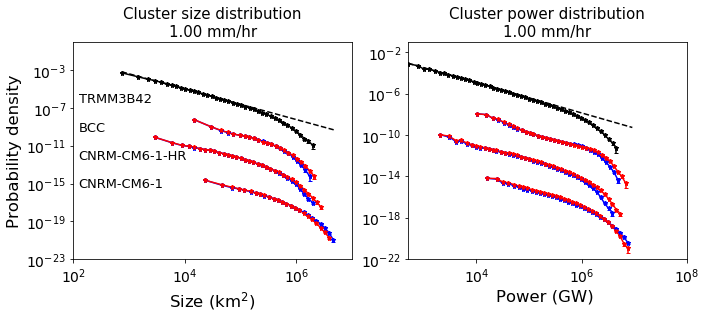

In [16]:
### set the plot specs:
### size
fig=plt.figure(figsize=(11,4.))
## grid: 1 row , 2 colum plot
gs = gridspec.GridSpec(1, 2)
## assign separate name for each axis
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])


### create empty dictionaries to hold the legends 
ln1={}
ln2={}

### positions for some of the text on the plot
posy=[ 0.85, 0.9, 0.95, 0.725, .8, .875 ]
posx=[.65, 0.65, 0.65, .4, .4 ]
pos_slope=[0.65, 0.9]

for j,key in enumerate(data_keys):

    
    ### check the model name and extract corresponding SSP file ###
    model_name=(key.split('_')[0])
    model_fil_ssp=[i for i in model_names_SSP if model_name in i]

    ### if more than one SSP name is extracted, differentiate based on string split ###
    if len(model_fil_ssp)>1:
        for k in model_fil_ssp:
            if(k.split('_')[1])==model_name:
                model_fil_ssp=[k]
               
    size_pdf, power_pdf, am, cm, sz_scaled, pcp_clust_sz,sz_diff, pcp_clust_sz_diff=compute_pdfs(cluster_dict[key],pthresh_list[0])
    
    
    size_pdf,offsets_sz=prep_pdf(cluster_dict[key]['hist_pcp_sizes'][pthresh_list[0]],
             size_pdf, sz_diff, ref_size_pdf, sz_scaled, ref_sz_scaled, shifts[key])

    
    power_pdf,offsets_pow=prep_pdf(cluster_dict[key]['hist_pcp_clust_pow'][pthresh_list[0]],
             power_pdf, pcp_clust_sz_diff, ref_power_pdf, pcp_clust_sz, ref_pow_scaled, shifts[key])


    ### there are the start and end of the power law range: adjust according to eye ###
    
    marker_color='black' if model_name=='TRMM3B42' else 'blue'
            
    ax1.loglog(sz_scaled,size_pdf,marker='*',
                        c=marker_color,markersize=5)
    
    ln1[j]=ax1.errorbar(sz_scaled, size_pdf, yerr=offsets_sz,fmt='*',
                        c=marker_color,markersize=5,capsize=2.25)
    
    ax1.text(xlim_sz[0]*1.25,np.nanmax(ref_size_pdf[20]*shifts[key]),
             '%s'%(model_name),transform=ax1.transData,fontsize=13)
    
    
    ax2.loglog(pcp_clust_sz, power_pdf, marker='*',c=marker_color,markersize=5)
    ax2.errorbar(pcp_clust_sz, power_pdf, yerr=offsets_pow, fmt='*',
                        c=marker_color,markersize=5,capsize=2.25)

    
    
    ### if a matching SSP file is found, plot it on top
    
    if model_fil_ssp:
        size_pdf_ssp, power_pdf_ssp, am_ssp, cm_ssp, sz_scaled_ssp, pcp_clust_sz_ssp, sz_diff_ssp, pcp_clust_sz_diff_ssp=compute_pdfs(cluster_dict[model_fil_ssp[0]],
                                                                     pthresh_list[0])    
        
        
        size_pdf_ssp,offsets_sz_ssp=prep_pdf(cluster_dict[model_fil_ssp[0]]['hist_pcp_sizes'][pthresh_list[0]],
            size_pdf_ssp, sz_diff_ssp, ref_size_pdf, sz_scaled_ssp, ref_sz_scaled, shifts[key])
        
        ax1.loglog(sz_scaled_ssp,size_pdf_ssp, marker='*', c='red',markersize=5)
        ax1.errorbar(sz_scaled_ssp, size_pdf_ssp, yerr=offsets_sz_ssp,fmt='*',
                        c='red',markersize=5,capsize=2.25)

        power_pdf_ssp,offsets_pow_ssp=prep_pdf(cluster_dict[model_fil_ssp[0]]['hist_pcp_clust_pow'][pthresh_list[0]],
            power_pdf_ssp, pcp_clust_sz_diff_ssp, ref_power_pdf, pcp_clust_sz_ssp, ref_pow_scaled, shifts[key])
        
        ax2.loglog(pcp_clust_sz_ssp,power_pdf_ssp, marker='*', c='red',markersize=5)
        ax2.errorbar(pcp_clust_sz_ssp, power_pdf_ssp, yerr=offsets_pow_ssp,fmt='*',
                        c='red',markersize=5,capsize=2.25)

    ### The straight line fit to the power law range ###
    ### select portions of the curve bounded by the power law range ###
    
    pdf_pcp_sizes=fit_power_law_slope(sz_scaled,size_pdf,istrt_sz,iend_sz,5e6)
    pdf_pcp_pow=fit_power_law_slope(pcp_clust_sz,power_pdf,istrt_pow,iend_pow,1e7)
    
    if (j == 0):
        ax1.loglog(sz_scaled,pdf_pcp_sizes*1e0,linestyle='--',c=color_dicts[key])
        ax2.loglog(pcp_clust_sz,pdf_pcp_pow*1e0,linestyle='--',c=color_dicts[key])

        ### Set plot title and axis labels
        ax1.set_title("Cluster size distribution\n%.2f mm/hr"%(pthresh_list[0]),fontsize=title_fontsize)
        ax1.set_xlabel("Size ($\mathrm{km^2}$) ",fontsize=xlabel_fontsize)
        ax1.set_ylabel("Probability density",fontsize=ylabel_fontsize)
        ax1.set_xlim(xlim_sz)
        ax1.set_ylim(ylim_sz)
        ax1.yaxis.set_major_locator(plt.FixedLocator([1e0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10]))
        ax1.tick_params(which='both', labelsize=ticks_fontsize)
        
        ax2.set_title("Cluster power distribution\n%.2f mm/hr"%(pthresh_list[0]),fontsize=title_fontsize)
        ax2.set_xlabel("Power (GW) ",fontsize=xlabel_fontsize)
        ax2.set_xlim(xlim_pow)
        ax2.set_ylim(ylim_pow)
        ax2.yaxis.set_major_locator(plt.FixedLocator([1e-2, 1e-4, 1e-6, 1e-8, 1e-10,1e-12]))
        ax2.tick_params(which='both', labelsize=ticks_fontsize)

### Be careful to not overwrite figures, change file name as the number of models/time periods change
    
SAVE_FIG=False
if SAVE_FIG:
    dirp='./' ## current location, but change as needed
    save_fig_name=dirp+"compared_model_clusters_pdfs_%.2f"%(pthresh_list[0])+".pdf"

    plt.savefig(save_fig_name,format='pdf',dpi=150,bbox_inches='tight')

### Replot as a log linear ###

In [24]:
## x and yaxis limits for cluster size
xlim_sz=[1e2,0.5e7] 
ylim_sz=[1e-23,1e0] ##

## x and yaxis limits for cluster power
xlim_pow=[5e2,1.0e7] ##
ylim_pow=[1e-22,1e-1] ##

istrt_sz,iend_sz=0.5e6,5.0e6 
istrt_pow,iend_pow=1.8e6,8.0e6 

### Option to set the fitting limits separately for each model ###

In [29]:
# fit_limits_sz_dict={}
# fit_limits_pow_dict


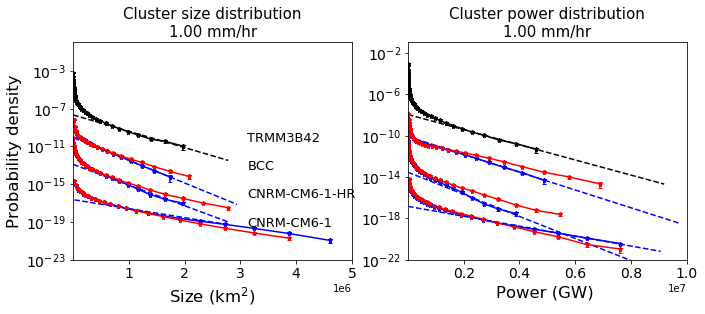

In [30]:
### set the plot specs:
### size
fig=plt.figure(figsize=(11,4.))
## grid: 1 row , 2 colum plot
gs = gridspec.GridSpec(1, 2)
## assign separate name for each axis
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])


### create empty dictionaries to hold the legends 
ln1={}
ln2={}

### positions for some of the text on the plot
posy=[ 0.85, 0.9, 0.95, 0.725, .8, .875 ]
posx=[.65, 0.65, 0.65, .4, .4 ]
pos_slope=[0.65, 0.9]

for j,key in enumerate(data_keys):

    istrt,iend=istrt_sz,iend_sz
    
    ### check the model name and extract corresponding SSP file ###
    model_name=(key.split('_')[0])
    model_fil_ssp=[i for i in model_names_SSP if model_name in i]

    ### if more than one SSP name is extracted, differentiate based on string split ###
    if len(model_fil_ssp)>1:
        for k in model_fil_ssp:
            if(k.split('_')[1])==model_name:
                model_fil_ssp=[k]
               
    size_pdf, power_pdf, am, cm, sz_scaled, pcp_clust_sz,sz_diff, pcp_clust_sz_diff=compute_pdfs(cluster_dict[key],pthresh_list[0])
    
    
    size_pdf,offsets_sz=prep_pdf(cluster_dict[key]['hist_pcp_sizes'][pthresh_list[0]],
             size_pdf, sz_diff, ref_size_pdf, sz_scaled, ref_sz_scaled, shifts[key])

    
    power_pdf,offsets_pow=prep_pdf(cluster_dict[key]['hist_pcp_clust_pow'][pthresh_list[0]],
             power_pdf, pcp_clust_sz_diff, ref_power_pdf, pcp_clust_sz, ref_pow_scaled, shifts[key])


    ### there are the start and end of the power law range: adjust according to eye ###
    
    marker_color='black' if model_name=='TRMM3B42' else 'blue'
            
    ax1.semilogy(sz_scaled,size_pdf,marker='*',
                        c=marker_color,markersize=5)
    
    ln1[j]=ax1.errorbar(sz_scaled, size_pdf, yerr=offsets_sz,fmt='*',
                        c=marker_color,markersize=5,capsize=2.25)
    
    ax1.text(xlim_sz[-1]*1./1.6,np.nanmax(ref_size_pdf[38]*shifts[key]),
             '%s'%(model_name),transform=ax1.transData,fontsize=13)
    
    
    ax2.semilogy(pcp_clust_sz, power_pdf, marker='*',c=marker_color,markersize=5)
    ax2.errorbar(pcp_clust_sz, power_pdf, yerr=offsets_pow, fmt='*',
                        c=marker_color,markersize=5,capsize=2.25)

    
    ### if a matching SSP file is found, plot it on top
    
    if model_fil_ssp:
        size_pdf_ssp, power_pdf_ssp, am_ssp, cm_ssp, sz_scaled_ssp, pcp_clust_sz_ssp, sz_diff_ssp, pcp_clust_sz_diff_ssp=compute_pdfs(cluster_dict[model_fil_ssp[0]],
                                                                     pthresh_list[0])    
        
        
        size_pdf_ssp,offsets_sz_ssp=prep_pdf(cluster_dict[model_fil_ssp[0]]['hist_pcp_sizes'][pthresh_list[0]],
            size_pdf_ssp, sz_diff_ssp, ref_size_pdf, sz_scaled_ssp, ref_sz_scaled, shifts[key])
        
        ax1.semilogy(sz_scaled_ssp,size_pdf_ssp, marker='*', c='red',markersize=5)
        ax1.errorbar(sz_scaled_ssp, size_pdf_ssp, yerr=offsets_sz_ssp,fmt='*',
                        c='red',markersize=5,capsize=2.25)

        power_pdf_ssp,offsets_pow_ssp=prep_pdf(cluster_dict[model_fil_ssp[0]]['hist_pcp_clust_pow'][pthresh_list[0]],
            power_pdf_ssp, pcp_clust_sz_diff_ssp, ref_power_pdf, pcp_clust_sz_ssp, ref_pow_scaled, shifts[key])
        
        ax2.semilogy(pcp_clust_sz_ssp,power_pdf_ssp, marker='*', c='red',markersize=5)
        ax2.errorbar(pcp_clust_sz_ssp, power_pdf_ssp, yerr=offsets_pow_ssp,fmt='*',
                        c='red',markersize=5,capsize=2.25)
        
#         pdf_pcp_sizes=fit_power_law_slope(sz_scaled_ssp,size_pdf_ssp,istrt_sz,iend_sz,3e6,'logylinearx')
#         pdf_pcp_pow=fit_power_law_slope(pcp_clust_sz_ssp,power_pdf_ssp,istrt_pow,iend_pow,7e6,'logylinearx')
#         ax1.semilogy(sz_scaled,pdf_pcp_sizes,linestyle='--',c='red')
#         ax2.semilogy(pcp_clust_sz,pdf_pcp_pow*1e0,linestyle='--',c='red')


    ### The straight line fit to the power law range ###
    ### select portions of the curve bounded by the power law range ###
    
    pdf_pcp_sizes=fit_power_law_slope(sz_scaled,size_pdf,istrt_sz,iend_sz,3e6,'logylinearx')
    pdf_pcp_pow=fit_power_law_slope(pcp_clust_sz,power_pdf,istrt_pow,iend_pow,1e7,'logylinearx')
    
    ax1.semilogy(sz_scaled,pdf_pcp_sizes,linestyle='--',c=marker_color)
    ax2.semilogy(pcp_clust_sz,pdf_pcp_pow*1e0,linestyle='--',c=marker_color)

        
    if (j == 0):
#         ax1.semilogy(sz_scaled,pdf_pcp_sizes,linestyle='--',c=color_dicts[key])
#         ax2.semilogy(pcp_clust_sz,pdf_pcp_pow*1e0,linestyle='--',c=color_dicts[key])

        ### Set plot title and axis labels
        ax1.set_title("Cluster size distribution\n%.2f mm/hr"%(pthresh_list[0]),fontsize=title_fontsize)
        ax1.set_xlabel("Size ($\mathrm{km^2}$) ",fontsize=xlabel_fontsize)
        ax1.set_ylabel("Probability density",fontsize=ylabel_fontsize)
        ax1.set_xlim(xlim_sz)
        ax1.set_ylim(ylim_sz)
        ax1.yaxis.set_major_locator(plt.FixedLocator([1e0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10]))
        ax1.tick_params(which='both', labelsize=ticks_fontsize)
        ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

        ax2.set_title("Cluster power distribution\n%.2f mm/hr"%(pthresh_list[0]),fontsize=title_fontsize)
        ax2.set_xlabel("Power (GW) ",fontsize=xlabel_fontsize)
        ax2.set_xlim(xlim_pow)
        ax2.set_ylim(ylim_pow)
        ax2.yaxis.set_major_locator(plt.FixedLocator([1e-2, 1e-4, 1e-6, 1e-8, 1e-10,1e-12]))
        ax2.tick_params(which='both', labelsize=ticks_fontsize)
        ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

### Be careful to not overwrite figures, change file name as the number of models/time periods change
    
SAVE_FIG=False
if SAVE_FIG:
    dirp='./' ## current location, but change as needed
    save_fig_name=dirp+"compared_model_clusters_pdfs_%.2f"%(pthresh_list[0])+".pdf"

    plt.savefig(save_fig_name,format='pdf',dpi=150,bbox_inches='tight')